In [ ]:
import mlflow
from mlflow_for_ml_dev.src.utils.folder_operations import get_project_root

# set mlflow tracking uri
mlflow.set_tracking_uri(uri=(get_project_root() / 'mlruns').as_uri())

# Signature Enforcement

In [ ]:
model_uri = 'runs:/eb434f38d33f40878f4c387ba82b0881/rfc'

In [ ]:
# loading sklearn model
sk_model = mlflow.sklearn.load_model(model_uri)
print(type(sk_model).__name__)

In [ ]:
# loading pyfunc model
pyfunc_model = mlflow.pyfunc.load_model(model_uri)
print(type(pyfunc_model).__name__)

In [ ]:
# loading iris dataset
from sklearn.datasets import load_iris
from pprint import pprint

data = load_iris(as_frame=True)

# loading data
X = data.data
y = data.target


## Data Type Validation

In [ ]:
# changin data type of one column to make it invalid
X_invalid = X.copy()
X_invalid['sepal length (cm)'] = X_invalid['sepal length (cm)'].astype(int)
X_invalid.info()

In [ ]:
sk_model.predict(X_invalid)  # this will work fine

In [ ]:
# predicting with pyfunc model
try:
    pyfunc_model.predict(X_invalid)  # this will raise an error
except Exception as e:
    print(e)

## Schema Validation

In [ ]:
# changin column name to make it invalid
X_invalid = X.copy()
X_invalid['sepal length (cm) invalid'] = X_invalid['sepal length (cm)']
X_invalid = X_invalid.drop(columns=['sepal length (cm)'])
X_invalid.head()

In [ ]:
# predicting with sk model
try:
    sk_model.predict(X_invalid)  # this will not work due to sklearn validation
except Exception as e:
    print(e)

In [ ]:
# run to show that the validation comes from sklearn
sk_model.predict(X_invalid) 

In [ ]:
# predicting with pyfunc model
try:
    pyfunc_model.predict(X_invalid)  # this will raise an error due to mlfow validation
except Exception as e:
    print(e)

# Working with Optional Columns

In [ ]:
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema
from mlflow.types.schema import ColSpec

In [ ]:
# To create a schema for the iris dataset, we need to create a list of ColSpec objects
col_specifications = [
    ColSpec(type="double", name=feature_name, required=True) for feature_name in data.feature_names
    ]

optional_column = [ColSpec(type="double", name="optional_column", required=False)]
# schema for the model input
model_input = Schema(inputs = col_specifications+optional_column)

In [ ]:
# creating model output schema
model_output = Schema(inputs= [ColSpec(type="integer", name="species", required=True)])

In [ ]:
# model signature
model_signature = ModelSignature(inputs=model_input, outputs=model_output)
pprint(model_signature.to_dict(), indent=2)

In [ ]:
class CustomModel(mlflow.pyfunc.PythonModel):
    
    def predict(self, context, model_input):
        "more logic can be added here"
        return model_input
    
# log custom model
with mlflow.start_run(run_name="custom-model-with-optional-inputs") as run:
    mlflow.pyfunc.log_model(
        artifact_path="custom_model",
        python_model=CustomModel(),
        signature=model_signature
    )

# loading custom model
custom_model = mlflow.pyfunc.load_model(f"runs:/{run.info.run_id}/custom_model")

In [ ]:
# Modify X to include the optional column
X_with_optional_column = X.copy()
X_with_optional_column['optional_column'] = 100*X["petal length (cm)"]
X_with_optional_column.head()


In [ ]:
custom_model.predict(X_with_optional_column)

In [ ]:
# Modify X to remove a mandatory column
X_with_missing_column = X.copy()
X_with_missing_column = X_with_missing_column.drop(columns=["sepal length (cm)"])
X_with_missing_column.head()

In [ ]:
try:
    custom_model.predict(X_with_missing_column)  # this will raise an error
except Exception as e:
    print(e)

# Infer Model Signature

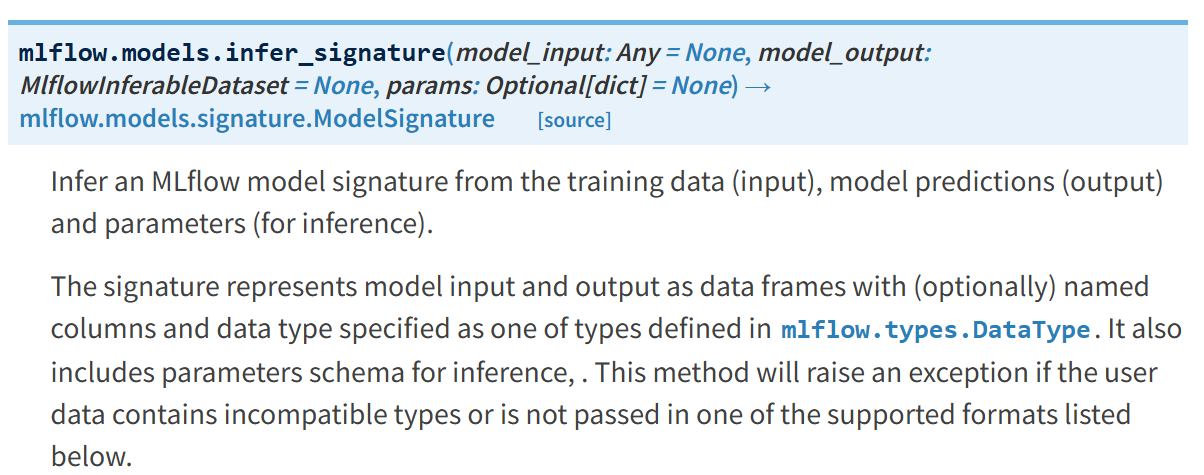

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from mlflow.models.signature import infer_signature
from pprint import pprint


In [ ]:
# Load iris dataset
data = load_iris(as_frame=True)
X = data.data
y = data.target
# rename y colunm to species
y.name = "species"

# Create a signature for the model
model_signature = infer_signature(model_input=X, model_output=y)

pprint(model_signature.to_dict(), indent=2)

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X, y)

# Log the model
with mlflow.start_run(run_name="log-decision-tree-classifier") as run:
    mlflow.sklearn.log_model(
        sk_model=dtc,
        artifact_path='model',
        signature=model_signature
    )


## Optional fields when working with infer_signature

In [ ]:
X_with_optional_column.head()

In [ ]:
infer_signature_with_optional_column = infer_signature(model_input=X_with_optional_column, model_output=y)
pprint(infer_signature_with_optional_column.to_dict(), indent=2)

In [ ]:
X_with_optional_dict = X_with_optional_column.iloc[0].to_dict()
X_with_optional_dict['optional_column'] = None
print(X_with_optional_dict)

In [ ]:
infer_signature_with_optional_column = infer_signature(model_input=X_with_optional_dict, model_output=y)

In [ ]:
pprint(infer_signature_with_optional_column.to_dict(), indent=2)